In [17]:
import numpy as np
import scipy
from scipy.stats import uniform, gamma, norm, beta
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

## Monte Carlo

Monte Carlo methods are a group of methods that use random sampling to solve problems that are either stochastic or deterministic.

Example problems:

* generating samples from distribution with pdf $p$
* estimating values of integrals (expected values et c)

-----

### Importance sampling

-----

Importance sampling is used to estimate expected values

$$E(f(X)) = \int_{a}^{b} f(z) p(z) dz$$

Using samples from some other distribution $q$. This is useful because we do not need to strictly sample from $p$ (which is realistic in practice).

We do this by *weighing* samples ($X'$ is distributed with $q$)

$$w(z) = \frac{f(z)p(z)}{q(z)}$$

Then $$E(w(X')) = \int_{a}^{b} \frac{f(z)p(z)}{q(z)} q(z) dz = \int_{a}^{b} f(z) p(z) dz = E(f(X)) $$

That means that for estimating $E(f(X))$ we can just use samples from $q$.

**Warning** this assumes that $q(z) = 0$ implies $p(z) = 0$, otherwise $w(z)$ would be undefined.

In simple terms that means that $p$'s support has to be a subset of $q$'s support.

In [2]:
def importance_sample_expected_value(f, p_pdf, q_pdf, samples):
    """
    Estimate expected value of f(X) where X ~ p, with samples from q
    """
    sample_f = f(samples)
    weights = p_pdf(samples) / q_pdf(samples)
    return np.mean(weights * sample_f)


def get_importance_sampling_variance(correct_value, f, p_pdf, q_pdf, sampler, n_runs=100):
    estimates = [importance_sample_expected_value(f, p_pdf, q_pdf, sampler()) for _ in range(n_runs)]
    return np.mean((estimates - correct_value) ** 2)

In [3]:
N = 100000

In [4]:
correct_value = 1 - norm.cdf(3)
correct_value

0.0013498980316301035

In [5]:
f = lambda x: x > 3

Estimation with straightforward mean:

In [6]:
simple_estimate = np.mean(f(np.random.randn(N)))
simple_estimate

0.00141

Estimation with $q$ ~ $\mathcal{N}(4,1)$

In [7]:
importance_sample_estimate = importance_sample_expected_value(f, norm.pdf, lambda x: norm.pdf(x, loc=4, scale=1), np.random.randn(N) + 4)
importance_sample_estimate

0.0013515238958539126

Variance of simple estimator

In [8]:
simple_estimates = np.mean(f(np.random.randn(N, 100)), axis=0)
simple_estimate_variance = np.mean((simple_estimates - correct_value) ** 2)
simple_estimate_variance

1.3543031501197454e-08

Variance of importance sampling

In [9]:
importance_sampling_variance = get_importance_sampling_variance(correct_value, f, norm.pdf, lambda x: norm.pdf(x, loc=4, scale=1), sampler=lambda: np.random.randn(N) + 4)
importance_sampling_variance

9.164407538056188e-11

-----

### Rejection sampling

-----


For simplicity let's assume we want to sample distribution with bounded support (without loss of generality supported on $[0,1]$).

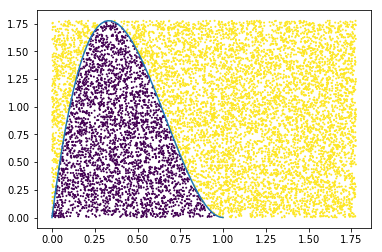

In [32]:
x = np.linspace(0, 1)


pdf_value = beta.pdf(x, 2, 3)


points_x = np.random.uniform(0, max(pdf_value), size=10000)
points_y = np.random.uniform(0, max(pdf_value), size=10000)

plt.plot(x, pdf_value);
plt.scatter(points_x, points_y, s=1, c=(beta.pdf(points_x, 2, 3) < points_y));

Using the above picture two things come to mind:

- reject samples over the pdf, thus getting only samples from interesting distribution
- use rejected samples to estimate measure under pdf relatively to bounding box

The second method also generalizes to higher dimensions and more complex shapes (for example estimating volume of a set bounded by hypercube)